In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from modelling import *

In [2]:
%load_ext autoreload
%autoreload 2
from modelling import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
lr = 1e-4
batch_size = 50
dropout_keep_prob = 0.5
embedding_size = 300
max_document_length = 100  # each sentence has until 100 words
dev_size = 0.8 # split percentage to train\validation data
max_size = 5000 # maximum vocabulary size
seed = 1
num_classes = 3
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
num_epochs = 6

In [181]:
data_class  = DataClass(use_prediction= True,use_enhanced=True,custom=True)
data_class.create_dataset()
modelling_data = DataModel(data = data_class.data_model,
                           custom_test_index=data_class.enhanced_index,
                           max_len = 200,
                           custom=True)

modifying features
['link', 'employer', 'occupation', 'name_sex', 'firstname_lower']
['link', 'employer', 'occupation', 'name_sex', 'firstname_lower_enhanced']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [182]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [195]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras import Input

vocab_size = modelling_data.vocab_size
embed_size = 500
hidden_size2 =200
hidden_size3 = 200
hidden_size4 = 200
output_dim =1 
dropout_rate = 0.1
max_document_length = modelling_data.max_len
modelling_data.create_padding()
model = Sequential()
model.add(Input(shape=(max_document_length,)))  # input layer specifying the input shape
model.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=max_document_length))
model.add(Flatten())  # flattening the output of the embedding layer to fit into dense layers
model.add(Dense(hidden_size2, activation='leaky_relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(hidden_size3, activation='leaky_relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(hidden_size4, activation='leaky_relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(output_dim, activation='sigmoid' if output_dim == 1 else 'softmax'))  # for binary classification use 'sigmoid', for multi-class use 'softmax'

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy' if output_dim == 1 else 'categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to check if everything is as expected
model.summary()


Shape of training tensor:  (205, 200)
Shape of testing tensor:  (27, 200)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 200, 500)          250000    
                                                                 
 flatten_41 (Flatten)        (None, 100000)            0         
                                                                 
 dense_177 (Dense)           (None, 200)               20000200  
                                                                 
 dropout_128 (Dropout)       (None, 200)               0         
                                                                 
 dense_178 (Dense)           (None, 200)               40200     
                                                                 
 dropout_129 (Dropout)       (None, 200)               0         
                                             

In [196]:
num_epochs = 300
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(modelling_data.training_padded,
                    modelling_data.y_train,
                    epochs=num_epochs, 
                    validation_split = 0.2,
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/300
6/6 - 2s - loss: 1.8645 - accuracy: 0.4695 - val_loss: 0.7181 - val_accuracy: 0.6341 - 2s/epoch - 331ms/step
Epoch 2/300
6/6 - 1s - loss: 1.0116 - accuracy: 0.4939 - val_loss: 0.7645 - val_accuracy: 0.6341 - 1s/epoch - 177ms/step
Epoch 3/300
6/6 - 1s - loss: 0.8486 - accuracy: 0.4756 - val_loss: 0.6771 - val_accuracy: 0.6341 - 1s/epoch - 218ms/step
Epoch 4/300
6/6 - 1s - loss: 0.6845 - accuracy: 0.6037 - val_loss: 0.8038 - val_accuracy: 0.3659 - 1s/epoch - 220ms/step
Epoch 5/300
6/6 - 1s - loss: 0.6408 - accuracy: 0.6159 - val_loss: 0.5934 - val_accuracy: 0.6341 - 1s/epoch - 211ms/step
Epoch 6/300
6/6 - 1s - loss: 0.6868 - accuracy: 0.5732 - val_loss: 0.6570 - val_accuracy: 0.4390 - 1s/epoch - 204ms/step
Epoch 7/300
6/6 - 1s - loss: 0.4466 - accuracy: 0.7500 - val_loss: 0.2944 - val_accuracy: 0.9268 - 1s/epoch - 219ms/step
Epoch 8/300
6/6 - 1s - loss: 0.2307 - accuracy: 0.9573 - val_loss: 0.1918 - val_accuracy: 0.9512 - 1s/epoch - 208ms/step
Epoch 9/300
6/6 - 1s - loss: 0.0

Text(0.5, 0, 'epoch')

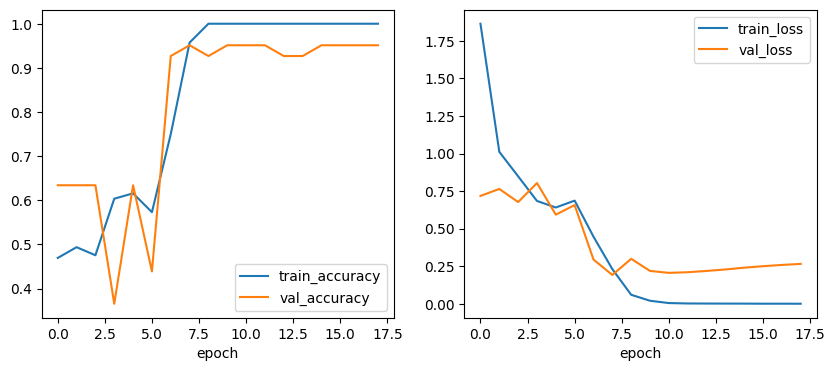

In [197]:
train_loss = pd.DataFrame(model.history.history['loss'],columns = ['train_loss'])
val_loss = pd.DataFrame(model.history.history['val_loss'],columns = ['val_loss'])
train_accuracy = pd.DataFrame(model.history.history['accuracy'],columns = ['train_accuracy'])
val_accuracy = pd.DataFrame(model.history.history['val_accuracy'],columns = ['val_accuracy'])
accuracy = train_accuracy.join(val_accuracy)
loss = train_loss.join(val_loss)
fig,axes = plt.subplots(nrows=1,ncols=2,figsize = (10,4))
accuracy.plot(ax=axes[0])
axes[0].set_xlabel('epoch')

loss.plot(ax = axes[1])
axes[1].set_xlabel('epoch')

In [198]:
train_dense_results = model.evaluate(modelling_data.training_padded, np.asarray(modelling_data.y_train), verbose=2, batch_size=256)
test_dense_results = model.evaluate(modelling_data.testing_padded, modelling_data.y_test)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Test accuracy: {test_dense_results[1]*100:0.2f}')

1/1 - 0s - loss: 0.0532 - accuracy: 0.9902 - 89ms/epoch - 89ms/step
1/1 [==============================] - 0s 56ms/step - loss: 1.6596 - accuracy: 0.7778
Train accuracy: 99.02
Test accuracy: 77.78
